In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv("edd_cf4_refined.csv", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.Vmod / 75.)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']
df['gr'] = df['g***'] - df['r***']
df['gz'] = df['g***'] - df['z***']
df['rz'] = df['r***'] - df['z***']
df['ri'] = df['r***'] - df['i***']

print(df.columns)
print(len(df))

df.head()

Index(['PGC', 'Name', 'Vhel', 'Vls', 'u', 'g', 'r', 'i', 'z', 'w1',
       ...
       'Mr_75', 'Mi_75', 'Mz_75', 'M1_75', 'M2_75', 'gi', 'gr', 'gz', 'rz',
       'ri'],
      dtype='object', length=121)
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PGC,Name,Vhel,Vls,u,g,r,i,z,w1,...,Mr_75,Mi_75,Mz_75,M1_75,M2_75,gi,gr,gz,rz,ri
0,2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,...,-34.024557,-34.024557,-34.024557,-22.134557,-21.504557,0.00,0.00,0.00,0.00,0.00
1,4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,...,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026,0.47,0.26,0.52,0.26,0.21
2,12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,...,-34.620362,-34.620362,-34.620362,-21.030362,-20.390362,0.00,0.00,0.00,0.00,0.00
3,16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,...,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429,0.78,0.50,0.96,0.46,0.28
4,55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,...,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131,0.31,0.21,0.36,0.15,0.10


sig_int:     0.0000      0.6911
Computing sig_int
sig_int:     0.0000      0.6911
sig_int:     0.0749     -0.4304
sig_int:     0.0461     -0.0264
sig_int:     0.0443      0.0029
sig_int:     0.0445     -0.0004
sig_int:     0.0445      0.0000
Computing sig_int error
sig_int:     0.0445      0.0306
sig_int:     0.0749     -0.3998
sig_int:     0.0467     -0.0049
sig_int:     0.0464      0.0004
sig_int:     0.0464     -0.0000
Repeat at best fitting solution
sig_int:     0.0445      0.0000
################# Values and formal errors ################
 intercept:  1.5773 +/- 0.0045
     slope:  0.4357 +/- 0.0068
   scatter:  0.0445 +/- 0.0019
Observed rms scatter: 0.070
Spearman r=0.77 and p=0
Pearson r=0.64 and p=9.5e-253
##########################################################
seconds 25.26
0.4356745724772873 1.5772902769378552


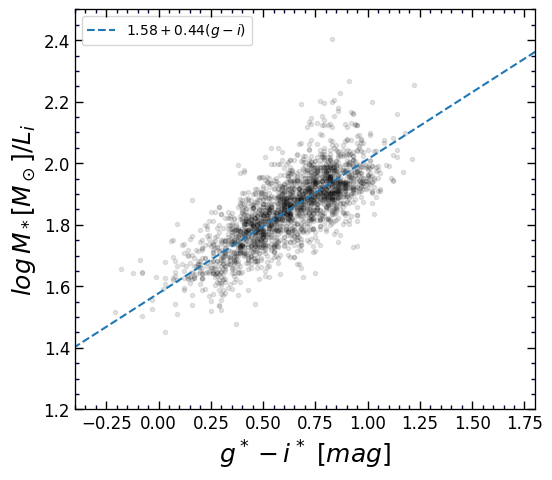

In [5]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)


set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)


def func(x, m, b):
    return m*x+b
    


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

gi = np.linspace(-1,2)
# ax.plot(gi, 0.7*gi+1.15, 'r-', label=r'$\Upsilon^*_i=-0.68+0.70(g-i)$')
# ax.plot(gi, m0*gi+b0, 'b-', label=r'$\Upsilon_*=-0.68+0.7(g-i)$')
ax.plot(gi, m*gi+b, '--', label=r'$1.58+0.44(g-i)$')


mask = ~mcfit.mask
xx = X0[mask]
yy = Y0[mask]

yy0 = m*xx+b
xx1 = xx[yy>yy0]
yy1 = yy[yy>yy0]
# ax.plot(xx1, yy1, 'r.', alpha=0.5)


yy0 = m*xx+b
xx1 = xx[yy<yy0]
yy1 = yy[yy<yy0]
# ax.plot(xx1, yy1, 'b.', alpha=0.5)

print(m, b)


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{i}$', fontsize=18)

ax.legend()        

sig_int:     0.0000      0.2979
Computing sig_int
sig_int:     0.0000      0.2979
sig_int:     0.0736     -0.4925
sig_int:     0.0277      0.0738
sig_int:     0.0357     -0.0423
sig_int:     0.0328      0.0014
sig_int:     0.0329      0.0001
sig_int:     0.0329     -0.0001
Computing sig_int error
sig_int:     0.0329      0.0305
sig_int:     0.0736     -0.4619
sig_int:     0.0354     -0.0080
sig_int:     0.0349     -0.0008
sig_int:     0.0348     -0.0000
sig_int:     0.0348      0.0002
Repeat at best fitting solution
sig_int:     0.0329     -0.0001
################# Values and formal errors ################
 intercept:  1.5653 +/- 0.0045
     slope:  0.5974 +/- 0.0068
   scatter:  0.0329 +/- 0.0019
Observed rms scatter: 0.069
Spearman r=0.86 and p=0
Pearson r=0.81 and p=0
##########################################################
seconds 30.75


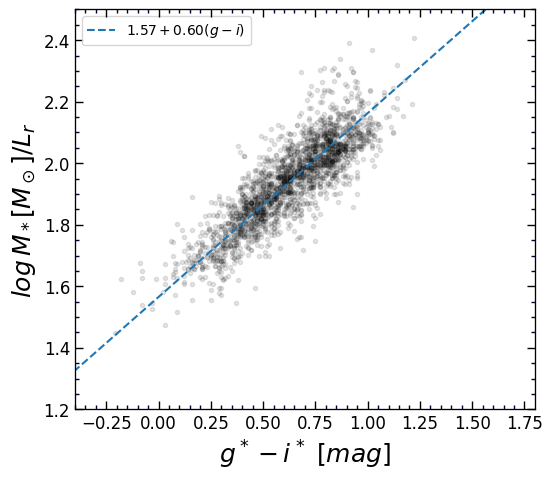

In [6]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)


set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-i)$')


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{r}$', fontsize=18)

ax.legend()        

sig_int:     0.0000      0.7990
Computing sig_int
sig_int:     0.0000      0.7990
sig_int:     0.0725     -0.4201
sig_int:     0.0475     -0.0548
sig_int:     0.0440      0.0282
sig_int:     0.0452      0.0044
sig_int:     0.0454      0.0004
sig_int:     0.0454     -0.0001
Computing sig_int error
sig_int:     0.0454      0.0306
sig_int:     0.0725     -0.3894
sig_int:     0.0474     -0.0218
sig_int:     0.0466      0.0081
sig_int:     0.0468     -0.0105
sig_int:     0.0467      0.0062
sig_int:     0.0467     -0.0093
sig_int:     0.0467      0.0058
Repeat at best fitting solution
sig_int:     0.0454     -0.0001
################# Values and formal errors ################
 intercept:  1.5924 +/- 0.0044
     slope:  0.3512 +/- 0.0067
   scatter:  0.0454 +/- 0.0013
Observed rms scatter: 0.068
Spearman r=0.7 and p=0
Pearson r=0.29 and p=5.5e-42
##########################################################
seconds 32.25


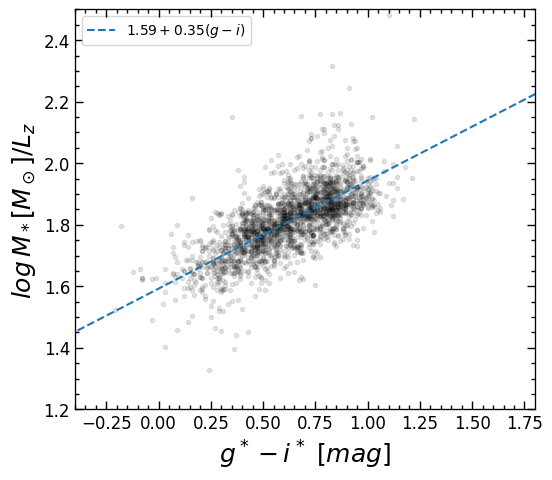

In [7]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mz_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)


set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-i)$')


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{z}$', fontsize=18)

ax.legend()        

sig_int:     0.0000     -0.1945
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1945
################# Values and formal errors ################
 intercept:  1.5217 +/- 0.0058
     slope:  1.039 +/- 0.014
   scatter:  0. +/- 0.0
Observed rms scatter: 0.076
Spearman r=0.85 and p=0
Pearson r=0.85 and p=0
##########################################################
seconds 3.85


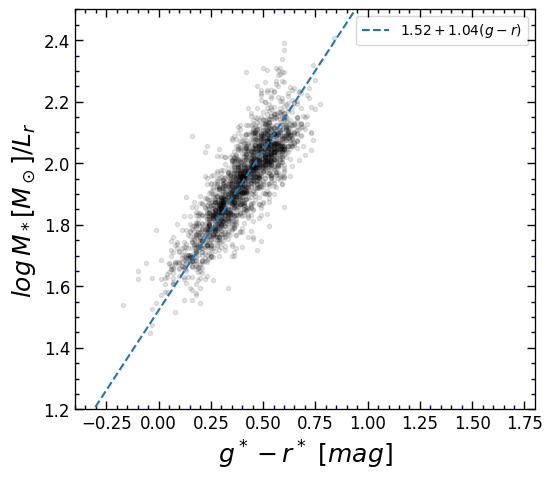

In [8]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mr_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gr.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)


set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)

mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-r)$')


ax.set_xlabel(r'$g^*-r^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{r}$', fontsize=18)

ax.legend()        

sig_int:     0.0000      1.1126
Computing sig_int
sig_int:     0.0000      1.1126
sig_int:     0.0734     -0.3652
sig_int:     0.0552     -0.0863
sig_int:     0.0500      0.0187
sig_int:     0.0510     -0.0009
sig_int:     0.0509     -0.0000
sig_int:     0.0509      0.0005
Computing sig_int error
sig_int:     0.0509      0.0307
sig_int:     0.0734     -0.3345
sig_int:     0.0528     -0.0080
sig_int:     0.0524     -0.0001
sig_int:     0.0524      0.0004
Repeat at best fitting solution
sig_int:     0.0509     -0.0000
################# Values and formal errors ################
 intercept:  1.6251 +/- 0.0043
     slope:  0.2602 +/- 0.0056
   scatter:  0.0509 +/- 0.0015
Observed rms scatter: 0.070
Spearman r=0.66 and p=4.9e-277
Pearson r=-0.68 and p=1.4e-290
##########################################################
seconds 23.15


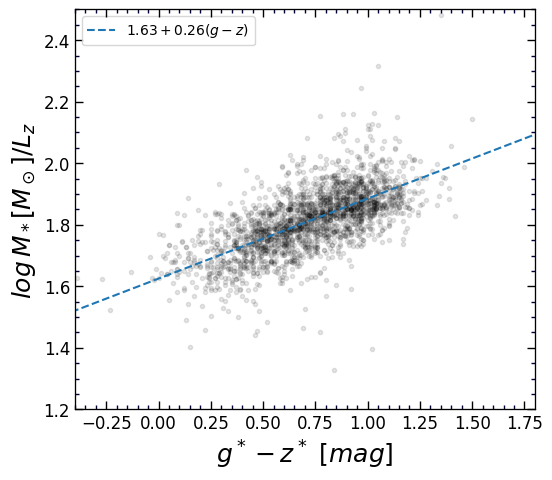

In [9]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mz_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.gz.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)

set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-z)$')


ax.set_xlabel(r'$g^*-z^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{z}$', fontsize=18)

ax.legend()        

sig_int:     0.0000      0.1769
Computing sig_int
sig_int:     0.0000      0.1769
sig_int:     0.0877     -0.5636
sig_int:     0.0210      0.0823
sig_int:     0.0369     -0.0702
sig_int:     0.0295      0.0059
sig_int:     0.0301      0.0005
sig_int:     0.0302      0.0000
sig_int:     0.0302     -0.0001
Computing sig_int error
sig_int:     0.0302      0.0306
sig_int:     0.0877     -0.5329
sig_int:     0.0333      0.0002
sig_int:     0.0333     -0.0000
Repeat at best fitting solution
sig_int:     0.0302      0.0000
################# Values and formal errors ################
 intercept:  1.5823 +/- 0.0047
     slope:  0.848 +/- 0.014
   scatter:  0.0302 +/- 0.0032
Observed rms scatter: 0.080
Spearman r=0.73 and p=0
Pearson r=0.16 and p=1.7e-14
##########################################################
seconds 29.44


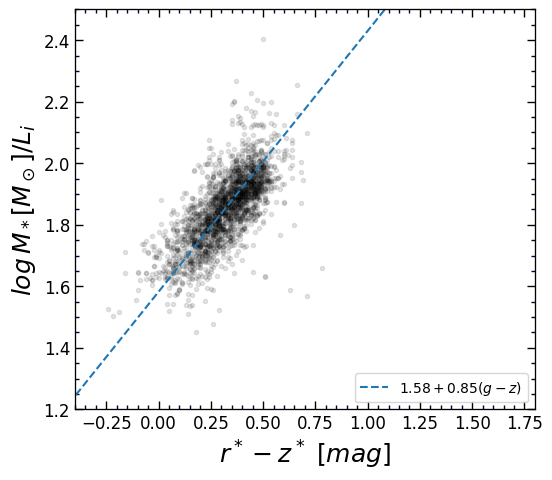

In [10]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


df['logMs'] =(np.log10(0.5) + 0.4*5.91)-0.4*df['M1_75']+0.4*df['Mi_75']

dff = df[(df.Qs>2)&(df.Qw>2)&(df.logMs<10)].dropna()

X0 = dff.rz.values
Y0 = dff.logMs.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)

set_axes(ax, (-0.4,1.8), (1.2,2.5), fontsize=12)


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.11*0.4, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(color, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-z)$')


ax.set_xlabel(r'$r^*-z^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*[M_\odot]/L_{i}$', fontsize=18)

ax.legend()        

sig_int:     0.0000     -0.3913
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.3913
################# Values and formal errors ################
 intercept:  -0.0326 +/- 0.0025
     slope:  0.5748 +/- 0.0041
   scatter:  0. +/- 0.0
Observed rms scatter: 0.063
Spearman r=0.85 and p=0
Pearson r=0.32 and p=3.5e-177
##########################################################
seconds 6.99


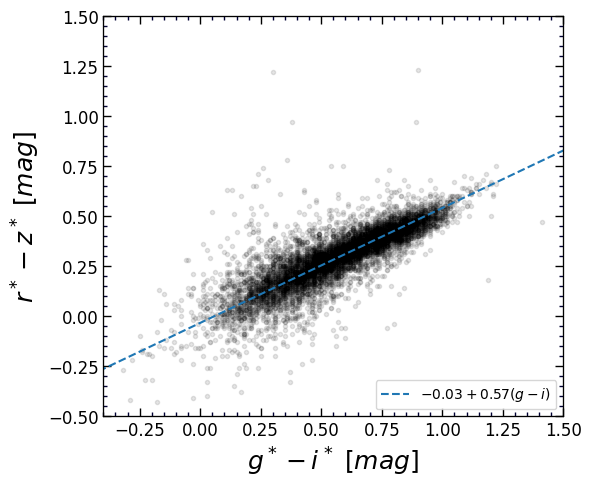

In [11]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


dff = df[(df.Qs>2)&(df.logMs<10)].dropna()

X0 = dff.gi.values
Y0 = dff.rz.values 

ax.plot(X0, Y0, 'k.', alpha=0.1)

set_axes(ax, (-0.4,1.5), (-0.5,1.5), fontsize=12)


mcfit = lts_linefit(X0, Y0, X0*0+0.07, Y0*0+0.07, clip=3., plot=False)
m = mcfit.ab[1]
b = mcfit.ab[0]

color = np.linspace(-1,2)
zp = '%.2f'%b
slope = '%.2f'%m
ax.plot(gi, m*color+b, '--', label=r'$'+zp+'+'+slope+'(g-i)$')


ax.set_xlabel(r'$g^*-i^* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$r^*-z^* \/\/[mag]$', fontsize=18) 

ax.legend() 

In [12]:
len(X0)

7435